<a href="https://colab.research.google.com/github/Pointbreak82/Bitcoin-price-prediction/blob/main/BITCOIN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mczielinski/bitcoin-historical-data


 78% 78.0M/100M [00:00<00:00, 159MB/s]
100% 100M/100M [00:00<00:00, 166MB/s] 


In [4]:
import os
import zipfile
from tqdm import tqdm


zip_file_name = 'bitcoin-historical-data.zip'


target_directory = '/content'


os.makedirs(target_directory, exist_ok=True)


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting", unit=" files", ncols=100):
        zip_ref.extract(file_info, target_directory)


Extracting: 100%|█████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/ files]


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense , LSTM , Dropout , Bidirectional
from keras.models import Sequential
from datetime import datetime
from numpy import sqrt
import matplotlib.pyplot as plt
import missingno as msno
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline


In [6]:
#import dataset
data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [8]:
data.describe(include="all")

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [9]:
tam1 = data.shape[0]
data.shape

(4857377, 8)

Amount of missing value by columns: 


Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

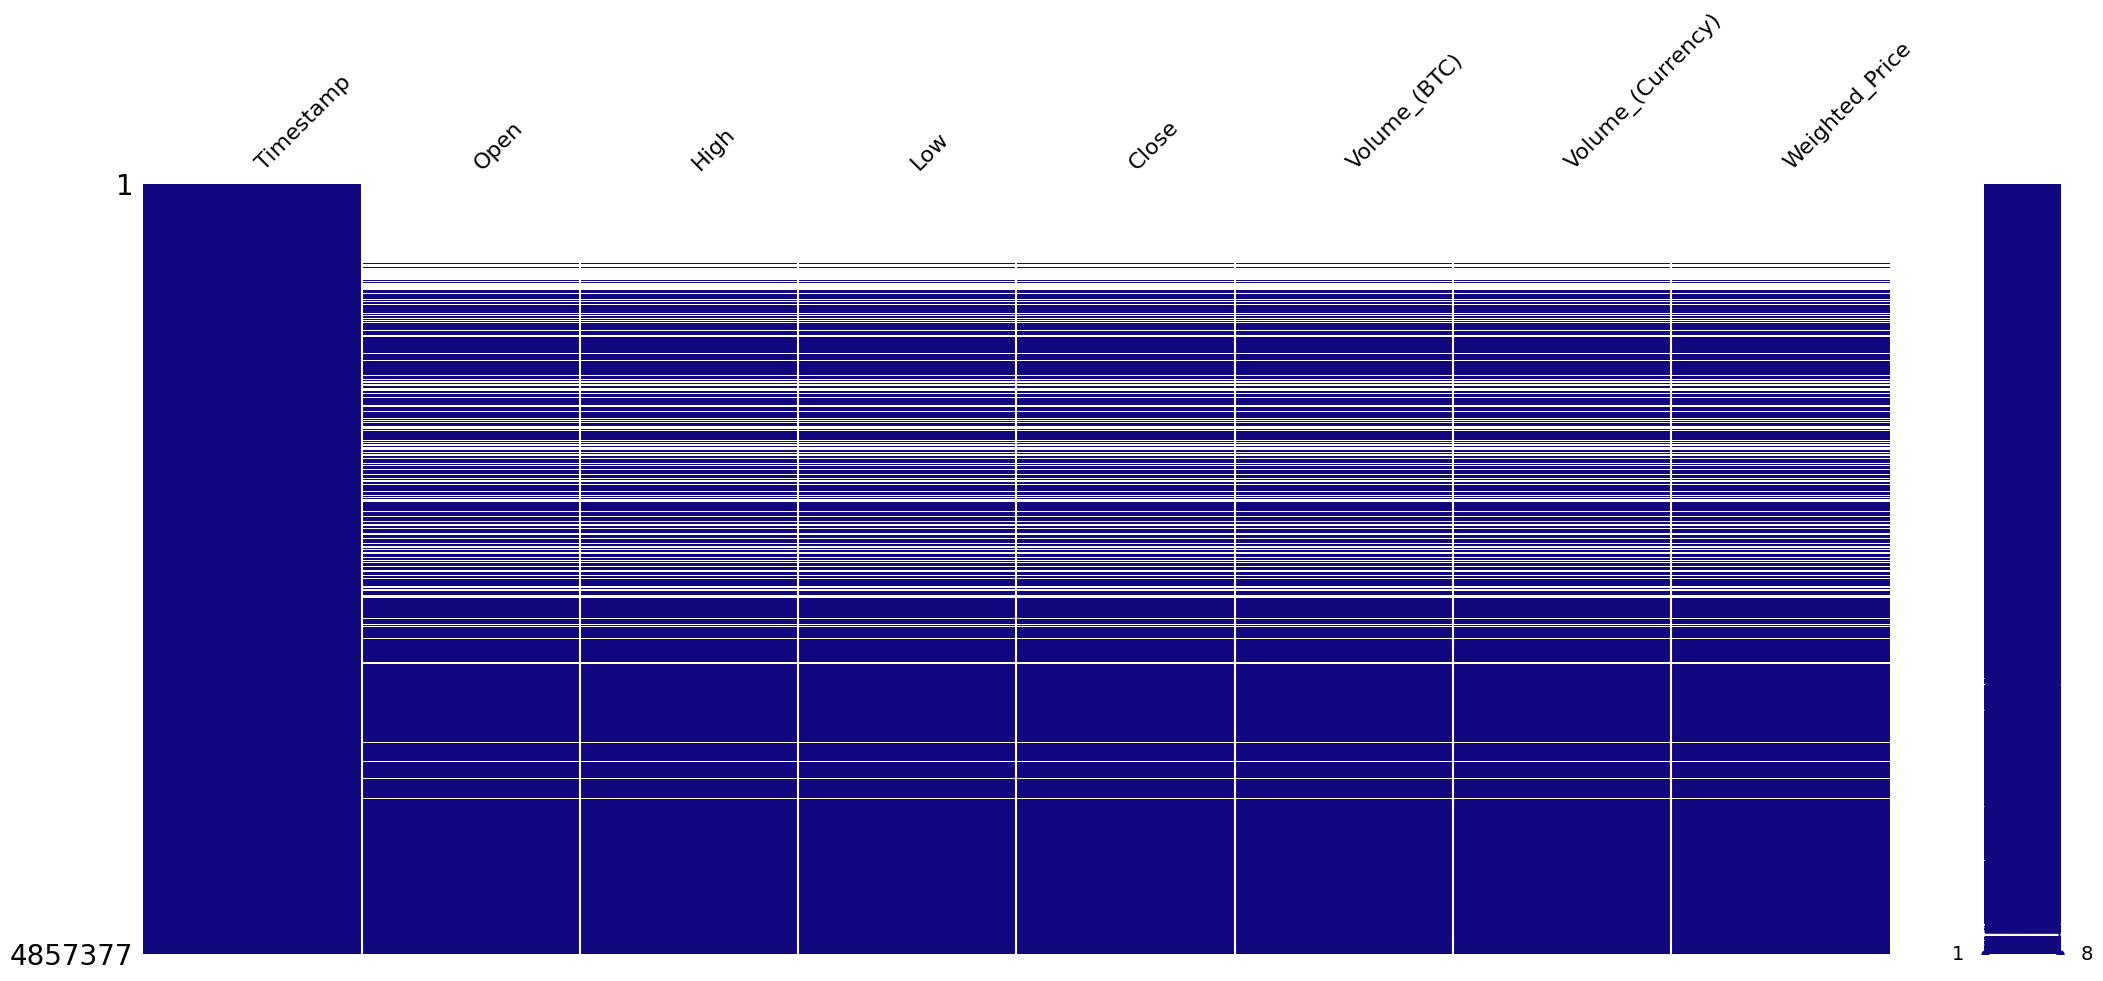

In [10]:
# missing values
import missingno as msno
%matplotlib inline
msno.matrix(data, color=(.07,.03,.5));

#  Amount of missing value
print("Amount of missing value by columns: ")
data.isnull().sum()

In [11]:
# Remove missing value and check
data = data.dropna().reset_index(drop=True)
#  Amount of missing value
print("Amount of missing value by columns: ")
data.isnull().sum()

Amount of missing value by columns: 


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [12]:
tam2 = data.shape[0]
p_remove = 100 - (tam2*100)/tam1
print(p_remove,"% of data were removed from the dataset.")

25.602459928475795 % of data were removed from the dataset.


In [13]:
# create a new column with date
data.Timestamp = pd.to_datetime(data.Timestamp , unit = 's')
data['date']= data.Timestamp.dt.date
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
2,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
3,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
4,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [14]:
data = data.groupby(data.date).mean()
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
date,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


<Axes: >

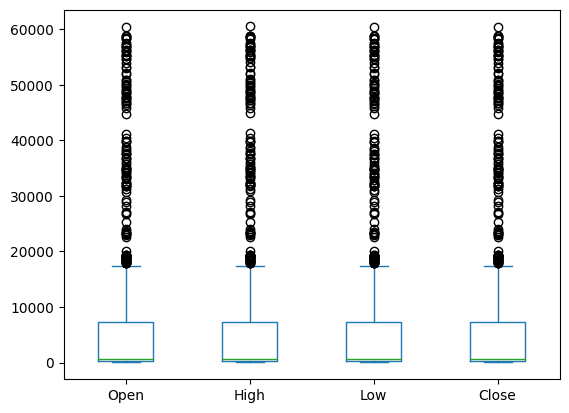

In [15]:
df = pd.DataFrame(data, columns=['Open', 'High', 'Low', 'Close'])
df.plot.box()

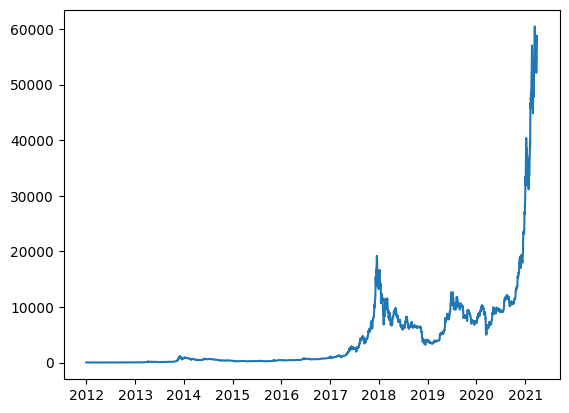

In [16]:
# imprima os dados
plt.plot(data['Weighted_Price'])

<Axes: >

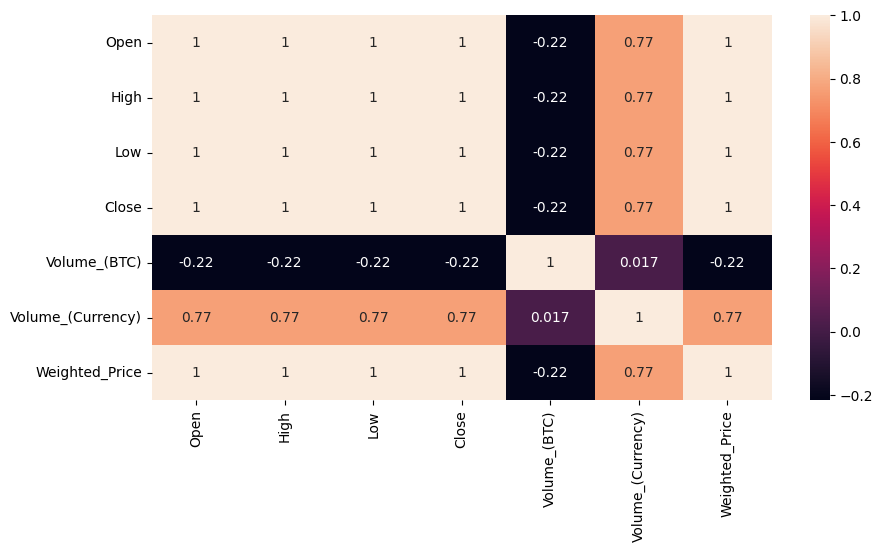

In [17]:
#Data correlation
plt.figure(figsize = (10,5))
sns.heatmap(data.corr(), annot = True)


# Data pre-processing

In [18]:
#There are some points with outliers, let's change to NaN and then call a method to fill the empty values
data['Weighted_Price'].replace(0, np.nan, inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)

In [19]:
# Let's use the weighted price as input to our recurring network
# Normalizes in the range between [0 and 1]
values = data['Weighted_Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [20]:
# 70% to train and 30% to test.
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

2363 1013


In [21]:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [22]:
# Enter with 1 single value window (Just one day)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

2362
1012


In [23]:
# reshape to neural network input format (instances, 1, 1)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# LSTM Model

In [24]:
model = Sequential()
model.add(Bidirectional(LSTM(32)))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1))
model.build(input_shape= (trainX.shape[0], trainX.shape[1], trainX.shape[2]))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (2362, 64)                8704      
 al)                                                             
                                                                 
 dense (Dense)               (2362, 128)               8320      
                                                                 
 dropout (Dropout)           (2362, 128)               0         
                                                                 
 dense_1 (Dense)             (2362, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (2362, 64)                0         
                                                                 
 dense_2 (Dense)             (2362, 1)                 65        
                                                        

## Function for training

In [62]:
def train_model(model, loss, optimizer, trainX, trainY):

  model.compile(loss=loss, optimizer=optimizer)
  #train model
  history = model.fit(trainX, trainY, epochs=5, batch_size= 200,  validation_data = (testX, testY))
  # # plot cost
  # plt.plot(history.history['loss'], label='train')
  # plt.plot(history.history['val_loss'], label='test')
  # plt.legend()
  # plt.show()



## Function to evaluate model


# Training and evaluating model

In [63]:
train_model(model, 'mse', 'adam', trainX, trainY)

Epoch 1/5
12/12 [==============================] - 7s 97ms/step - loss: 1.5617e-04 - val_loss: 6.2413e-04
Epoch 2/5
12/12 [==============================] - 0s 17ms/step - loss: 1.4238e-04 - val_loss: 6.0052e-04
Epoch 3/5
12/12 [==============================] - 0s 12ms/step - loss: 1.5761e-04 - val_loss: 2.0367e-04
Epoch 4/5
12/12 [==============================] - 0s 13ms/step - loss: 1.4430e-04 - val_loss: 3.4444e-04
Epoch 5/5
12/12 [==============================] - 0s 16ms/step - loss: 1.6295e-04 - val_loss: 2.1899e-04


32/32 [==============================] - 1s 2ms/step


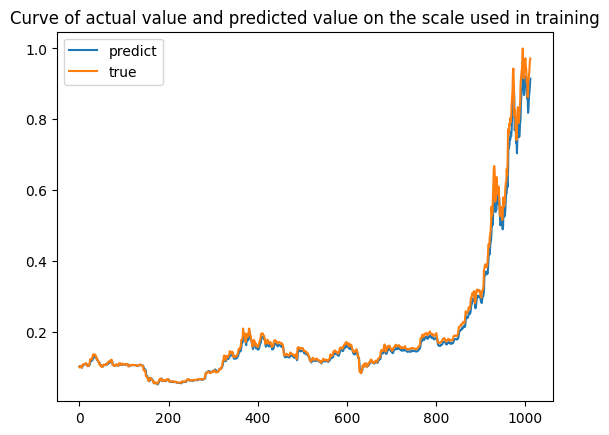

Test RMSE: 1086.846


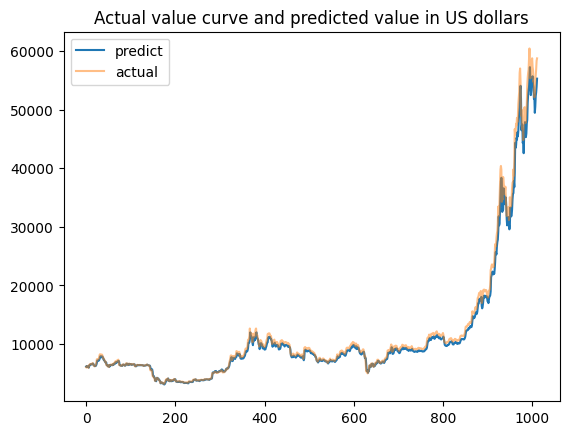

In [56]:
# test
evaluate_model(model, testX, testY)

# Predicting the next day

In [57]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def baseline(history):
  return np.mean(history)

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [58]:
def predict_next_day(model, testX, testY):

  yhat_inverse = scaler.inverse_transform(model.predict(testX).reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  show_plot([testY_inverse[0:200], yhat_inverse[201],baseline(testY_inverse[201])], 1, 'Next day prediction')

  print('predicted value of day 201: ', yhat_inverse[201])
  print('Actual value of day 201: ', testY_inverse[201])

32/32 [==============================] - 0s 3ms/step
predicted value of day 201:  [3736.0642]
Actual value of day 201:  [3636.6807]


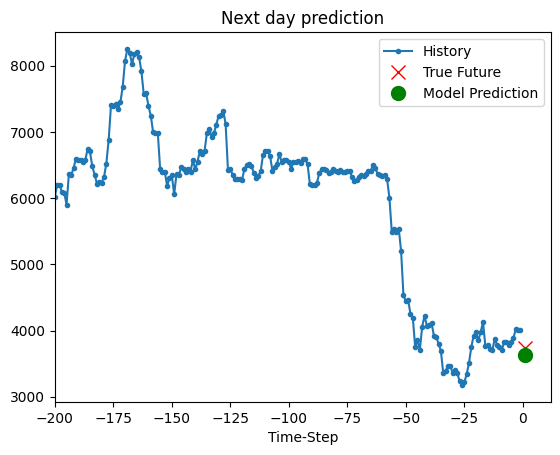

In [59]:
predict_next_day(model, testX, testY)